In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score,roc_auc_score
from sklearn.model_selection import GridSearchCV

In [44]:
df = pd.read_csv('stock fundamental data.csv')
df.head()
len(df)

50560

# Preprocessing data


In [45]:
# check for any null values in market value 
df.isnull().sum()

gvkey          0
tic            0
fyear         51
indfmt         0
consol         0
popsrc         0
datafmt        0
curcd         51
act        21788
ap         10863
at          6722
ceq         6843
che        13777
cogs       13868
dlc         7086
dlcch      31465
dltt        6884
dp          9347
dvc         7149
ib          6821
intan       7427
invt       12160
ivao       15275
lct        21720
lt          6792
nopio      17628
ppent       8714
rect       14032
sale       13865
spi         7300
txp        15200
txt         6826
xad        35615
xido        6821
xint       12512
xrd        31021
xsga       19673
costat         0
mkvalt     14697
dtype: int64

In [46]:
#create column 'future mkvalt' that holds the market value of the next year
condition1 = df['tic'].shift(-1) == df['tic']
condition2 = df['fyear'].shift(-1) == df['fyear'] + 1
df['future_mkvalt'] = np.where(condition1 & condition2, df['mkvalt'].shift(-1), np.nan)

#drop nulls
df = df.dropna(subset=['mkvalt', 'future_mkvalt'], how='all')

#percent change is the percent change in market value from one year to the next
df['percent_change'] = (df['future_mkvalt']-df['mkvalt'])/df['mkvalt']

#if percent change is greater than 20%, classify as undervalued
df['undervalued'] = (df['percent_change'] > 0.10)

In [47]:
#fill null expenses with 0
df['xrd'] = df['xrd'].fillna(0)
df['xad'] = df['xad'].fillna(0)
df['xsga'] = df['xsga'].fillna(0)
df['xint'] = df['xint'].fillna(0)
df['dlcch'] = df['dlcch'].fillna(0)



#combine all expenses columns into one column
expenses_list = ['xrd', 'xad', 'xsga', 'xint', 'nopio', 'cogs']
df['expenses'] = df[expenses_list].sum(axis=1)

df = df.drop(columns=expenses_list)

#delete duplicate rows due to formatting
condition = df['indfmt'] != "FS"
df = df[condition]

#drop unneccessary columns
df = df.drop(columns=['indfmt', 'consol', 'popsrc', 'datafmt', 'curcd', 'gvkey', 'costat'])




In [48]:
df.isnull().sum()

tic                  0
fyear                0
act               7179
ap                 277
at                  98
ceq                154
che                 99
dlc                102
dlcch                0
dltt               231
dp                1619
dvc                251
ib                 158
intan              538
invt               459
ivao              1468
lct               7119
lt                 148
ppent             1258
rect               309
sale               157
spi                525
txp               4285
txt                163
xido               159
mkvalt            1742
future_mkvalt     4277
percent_change    6019
undervalued          0
expenses             0
dtype: int64

In [49]:
#remove rows with null values
condition = df.isnull().sum(axis=1) < 1
df = df[condition]

In [50]:
df.head(20)

,tic,fyear,act,ap,at,ceq,che,dlc,dlcch,dltt,...,sale,spi,txp,txt,xido,mkvalt,future_mkvalt,percent_change,undervalued,expenses
0,AIR,2009.0,863.429,114.906,1501.042,746.906,79.370,100.833,-4.996,336.191,...,1352.151,-4.302,3.263,20.986,0.000,777.8348,1049.8206,0.349670,True,1243.600
1,AIR,2010.0,913.985,185.096,1703.727,835.845,57.433,114.075,54.991,329.802,...,1775.782,-1.536,0.000,35.364,-3.313,1049.8206,485.2897,-0.537740,False,1613.484
2,AIR,2011.0,1063.272,201.405,2195.653,864.649,67.720,122.865,0.000,669.489,...,2074.498,-13.864,0.000,25.480,0.000,485.2897,790.0029,0.627900,True,1891.119
3,AIR,2012.0,1033.700,149.300,2136.900,918.600,75.300,86.400,0.000,622.200,...,2167.100,-21.100,0.000,26.700,0.000,790.0029,961.3080,0.216841,True,1970.300
4,AIR,2013.0,1116.900,171.100,2199.500,999.500,89.200,69.700,10.000,564.300,...,2035.000,0.000,0.000,32.100,0.000,961.3080,1046.3954,0.088512,False,1824.100
5,AIR,2014.0,954.100,142.300,1515.000,845.100,54.700,69.000,-80.000,85.000,...,1594.300,-48.400,0.000,-28.500,64.700,1046.3954,842.5112,-0.194844,False,1537.300
6,AIR,2015.0,873.100,163.400,1442.100,865.800,31.200,12.000,60.000,136.100,...,1662.600,-0.400,1.100,18.800,7.200,842.5112,1200.3288,0.424704,True,1531.800
7,AIR,2016.0,888.500,177.400,1504.100,914.200,10.300,2.000,21.000,155.300,...,1767.600,2.600,12.300,24.100,6.300,1200.3288,1551.4580,0.292528,True,1624.700
8,AIR,2017.0,942.700,170.000,1524.700,936.300,41.600,0.000,-1.000,177.200,...,1748.300,0.000,0.000,3.500,-58.100,1551.4580,1046.7709,-0.325299,False,1628.900
11,AAL,2011.0,6757.000,1007.000,23848.000,-7111.000,4739.000,1518.000,0.000,6702.000,...,24022.000,-886.000,0.000,0.000,0.000,117.3438,266.5571,1.271591,True,24332.000


In [51]:
# check for any null values
df.isnull().sum()

tic               0
fyear             0
act               0
ap                0
at                0
ceq               0
che               0
dlc               0
dlcch             0
dltt              0
dp                0
dvc               0
ib                0
intan             0
invt              0
ivao              0
lct               0
lt                0
ppent             0
rect              0
sale              0
spi               0
txp               0
txt               0
xido              0
mkvalt            0
future_mkvalt     0
percent_change    0
undervalued       0
expenses          0
dtype: int64

In [53]:
# new length of df after processing
len(df)

18538

# Feature engineering

In [77]:
#feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# selected features and predict value
selected_features = list(df.drop(columns=['tic', 'fyear', 'undervalued']).columns)
X = df[selected_features]
y = df['undervalued']

#find best features
fs = SelectKBest(score_func=f_classif)

X_selected = fs.fit_transform(X,y)

(18538, 10)

In [84]:
# best features according to anova test 
fs.get_feature_names_out()

array(['ap', 'ceq', 'che', 'dp', 'invt', 'ppent', 'txp', 'xido',
       'future_mkvalt', 'percent_change'], dtype=object)

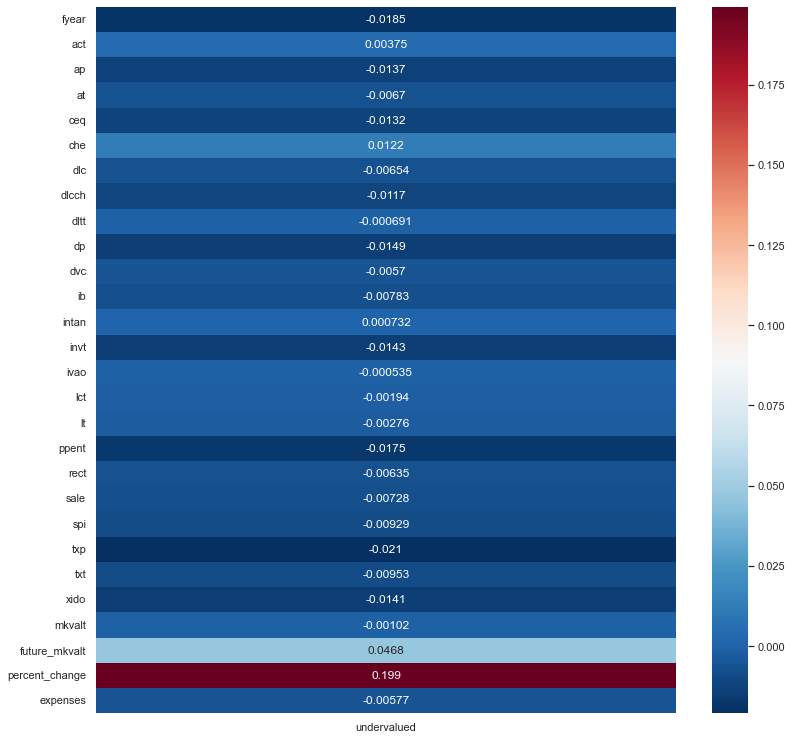

In [57]:
#create heatmap showing which values correlate most with undervalued helps select features
corr_mat = df.corr()

corr_targ = corr_mat[['undervalued']].drop(labels=['undervalued'])
fig, ax = plt.subplots(figsize = (13,13))
sns.heatmap(corr_targ, annot= True, fmt='.3',cmap='RdBu_r')
plt.show()

In [80]:
# Create training and test set from data 

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=45)





len(X_train)

14830

In [81]:
# explain this part 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
# choose model and hyperparameters then run a grids search to find best paramaters
rf_model = RandomForestClassifier()

params = [{'n_estimators': [100, 200, 400, 800],
        'max_depth': [3,5,7],
        'min_samples_leaf': [5,10, 25],
        'min_samples_split': [8, 10, 12],
        'max_features' : [2,6,8,None]
          }]

gs = GridSearchCV(rf_model,
                      param_grid=params,
                      scoring='precision',
                      cv=3, verbose=2, return_train_score=False)
gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   1.1s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   1.1s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   1.1s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400; total time=   2.2s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400; total time=   2.2s
[CV] END

[CV] END max_depth=3, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=800; total time=   4.5s
[CV] END max_depth=3, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=800; total time=   4.8s
[CV] END max_depth=3, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END max_depth=3, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=3, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=3, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=200; total time=   1.2s
[CV] END max_depth=3, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=200; total time=   1.1s
[CV] END max_depth=3, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=200; total time=   1.1s
[CV] END max_depth=3, max_features=2, min_samples_leaf=25, min

[CV] END max_depth=3, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=400; total time=   4.2s
[CV] END max_depth=3, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=800; total time=   8.5s
[CV] END max_depth=3, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=800; total time=   8.4s
[CV] END max_depth=3, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=800; total time=   8.6s
[CV] END max_depth=3, max_features=6, min_samples_leaf=10, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END max_depth=3, max_features=6, min_samples_leaf=10, min_samples_split=8, n_estimators=100; total time=   1.1s
[CV] END max_depth=3, max_features=6, min_samples_leaf=10, min_samples_split=8, n_estimators=100; total time=   1.1s
[CV] END max_depth=3, max_features=6, min_samples_leaf=10, min_samples_split=8, n_estimators=200; total time=   2.2s
[CV] END max_depth=3, max_features=6, min_samples_leaf=10, min_s

[CV] END max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=12, n_estimators=400; total time=   4.0s
[CV] END max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=12, n_estimators=400; total time=   4.1s
[CV] END max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=12, n_estimators=400; total time=   4.1s
[CV] END max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=12, n_estimators=800; total time=   8.3s
[CV] END max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=12, n_estimators=800; total time=   8.4s
[CV] END max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=12, n_estimators=800; total time=   8.4s
[CV] END max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.2s
[CV] END max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.2s
[CV] END max_depth=3, max_features=8, min_samples_leaf=5, mi

[CV] END max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=12, n_estimators=200; total time=   2.6s
[CV] END max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=12, n_estimators=200; total time=   2.5s
[CV] END max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=12, n_estimators=400; total time=   5.1s
[CV] END max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=12, n_estimators=400; total time=   5.1s
[CV] END max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=12, n_estimators=400; total time=   4.8s
[CV] END max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=12, n_estimators=800; total time=  10.2s
[CV] END max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=12, n_estimators=800; total time=  10.0s
[CV] END max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=12, n_estimators=800; total time=  10.2s
[CV] END max_depth=3, max_features=8, min_samples_leaf=2

[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.7s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   3.3s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   3.2s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   3.2s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=400; total time=   6.8s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=400; total time=   6.5s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=400; total time=   6.6s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=800; total time=  12.4s
[CV] END max_depth=3, max_features=None,

[CV] END max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=10, n_estimators=800; total time=  10.9s
[CV] END max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=10, n_estimators=800; total time=  10.9s
[CV] END max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=12, n_estimators=100; total time=   1.4s
[CV] END max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=12, n_estimators=100; total time=   1.4s
[CV] END max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=12, n_estimators=100; total time=   1.4s
[CV] END max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=12, n_estimators=200; total time=   2.7s
[CV] END max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=12, n_estimators=200; total time=   2.7s
[CV] END max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=12, n_estimators=200; total time=   2.8s
[CV] END max_depth=3, max_featur

[CV] END max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   2.2s
[CV] END max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.4s
[CV] END max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.4s
[CV] END max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   4.4s
[CV] END max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=12, n_estimators=200; total time=   1.1s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1

[CV] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   4.0s
[CV] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   4.0s
[CV] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   3.9s
[CV] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   8.0s
[CV] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   8.0s
[CV] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   8.0s
[CV] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.0s
[CV] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.0s
[CV] END max_depth=5, max_features=6, min_samples_leaf=5, min_sa

[CV] END max_depth=5, max_features=6, min_samples_leaf=25, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END max_depth=5, max_features=6, min_samples_leaf=25, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END max_depth=5, max_features=6, min_samples_leaf=25, min_samples_split=10, n_estimators=400; total time=   3.9s
[CV] END max_depth=5, max_features=6, min_samples_leaf=25, min_samples_split=10, n_estimators=400; total time=   3.9s
[CV] END max_depth=5, max_features=6, min_samples_leaf=25, min_samples_split=10, n_estimators=400; total time=   4.0s
[CV] END max_depth=5, max_features=6, min_samples_leaf=25, min_samples_split=10, n_estimators=800; total time=   7.8s
[CV] END max_depth=5, max_features=6, min_samples_leaf=25, min_samples_split=10, n_estimators=800; total time=   7.9s
[CV] END max_depth=5, max_features=6, min_samples_leaf=25, min_samples_split=10, n_estimators=800; total time=   7.7s
[CV] END max_depth=5, max_features=6, min_samples_leaf=2

[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   4.5s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   4.5s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   4.6s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10, n_estimators=800; total time=   9.1s
[CV] END max_depth=5, max_features=8, min_samples_leaf=1

[CV] END max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   2.7s
[CV] END max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   2.7s
[CV] END max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   2.7s
[CV] END max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   5.4s
[CV] END max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   5.4s
[CV] END max_depth=5, max_features=None,

[CV] END max_depth=5, max_features=None, min_samples_leaf=25, min_samples_split=8, n_estimators=800; total time=  10.8s
[CV] END max_depth=5, max_features=None, min_samples_leaf=25, min_samples_split=8, n_estimators=800; total time=  10.9s
[CV] END max_depth=5, max_features=None, min_samples_leaf=25, min_samples_split=8, n_estimators=800; total time=  10.9s
[CV] END max_depth=5, max_features=None, min_samples_leaf=25, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=5, max_features=None, min_samples_leaf=25, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=5, max_features=None, min_samples_leaf=25, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=5, max_features=None, min_samples_leaf=25, min_samples_split=10, n_estimators=200; total time=   2.7s
[CV] END max_depth=5, max_features=None, min_samples_leaf=25, min_samples_split=10, n_estimators=200; total time=   2.7s
[CV] END max_depth=5, max_features=

[CV] END max_depth=7, max_features=2, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.6s
[CV] END max_depth=7, max_features=2, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   2.6s
[CV] END max_depth=7, max_features=2, min_samples_leaf=10, min_samples_split=8, n_estimators=800; total time=   5.3s
[CV] END max_depth=7, max_features=2, min_samples_leaf=10, min_samples_split=8, n_estimators=800; total time=   5.7s
[CV] END max_depth=7, max_features=2, min_samples_leaf=10, min_samples_split=8, n_estimators=800; total time=   5.1s
[CV] END max_depth=7, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=7, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=7, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=7, max_features=2, min_samples_leaf=10, mi

[CV] END max_depth=7, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   2.2s
[CV] END max_depth=7, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=400; total time=   4.4s
[CV] END max_depth=7, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=400; total time=   4.4s
[CV] END max_depth=7, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=400; total time=   4.4s
[CV] END max_depth=7, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=   8.5s
[CV] END max_depth=7, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=   8.7s
[CV] END max_depth=7, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=   9.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END max_depth=7, max_features=6, min_samples_leaf=5, min_samples_s

[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8, n_estimators=200; total time=   2.2s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8, n_estimators=200; total time=   2.2s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8, n_estimators=200; total time=   2.3s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8, n_estimators=400; total time=   4.4s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8, n_estimators=400; total time=   4.3s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8, n_estimators=400; total time=   4.3s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8, n_estimators=800; total time=   8.8s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8, n_estimators=800; total time=   8.7s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_s

[CV] END max_depth=7, max_features=8, min_samples_leaf=10, min_samples_split=8, n_estimators=100; total time=   1.3s
[CV] END max_depth=7, max_features=8, min_samples_leaf=10, min_samples_split=8, n_estimators=100; total time=   1.2s
[CV] END max_depth=7, max_features=8, min_samples_leaf=10, min_samples_split=8, n_estimators=200; total time=   2.4s
[CV] END max_depth=7, max_features=8, min_samples_leaf=10, min_samples_split=8, n_estimators=200; total time=   2.3s
[CV] END max_depth=7, max_features=8, min_samples_leaf=10, min_samples_split=8, n_estimators=200; total time=   2.3s
[CV] END max_depth=7, max_features=8, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   4.8s
[CV] END max_depth=7, max_features=8, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   4.9s
[CV] END max_depth=7, max_features=8, min_samples_leaf=10, min_samples_split=8, n_estimators=400; total time=   4.8s
[CV] END max_depth=7, max_features=8, min_samples_leaf=10, min_s

[CV] END max_depth=7, max_features=8, min_samples_leaf=25, min_samples_split=12, n_estimators=800; total time=   9.6s
[CV] END max_depth=7, max_features=None, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.4s
[CV] END max_depth=7, max_features=None, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.4s
[CV] END max_depth=7, max_features=None, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.4s
[CV] END max_depth=7, max_features=None, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   2.7s
[CV] END max_depth=7, max_features=None, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   2.7s
[CV] END max_depth=7, max_features=None, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   2.7s
[CV] END max_depth=7, max_features=None, min_samples_leaf=5, min_samples_split=8, n_estimators=400; total time=   5.4s
[CV] END max_depth=7, max_features=None, min_samp

[CV] END max_depth=7, max_features=None, min_samples_leaf=10, min_samples_split=12, n_estimators=400; total time=   5.4s
[CV] END max_depth=7, max_features=None, min_samples_leaf=10, min_samples_split=12, n_estimators=800; total time=  10.9s
[CV] END max_depth=7, max_features=None, min_samples_leaf=10, min_samples_split=12, n_estimators=800; total time=  10.9s
[CV] END max_depth=7, max_features=None, min_samples_leaf=10, min_samples_split=12, n_estimators=800; total time=  10.9s
[CV] END max_depth=7, max_features=None, min_samples_leaf=25, min_samples_split=8, n_estimators=100; total time=   1.4s
[CV] END max_depth=7, max_features=None, min_samples_leaf=25, min_samples_split=8, n_estimators=100; total time=   1.4s
[CV] END max_depth=7, max_features=None, min_samples_leaf=25, min_samples_split=8, n_estimators=100; total time=   1.4s
[CV] END max_depth=7, max_features=None, min_samples_leaf=25, min_samples_split=8, n_estimators=200; total time=   2.7s
[CV] END max_depth=7, max_features=N

{'max_depth': 3,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 100}

In [82]:
# train model using best parameters then test scores
    
rf_model = gs.best_estimator_
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

# Evaluate and print model scores using accuracy, precision, recall, f1 scores, and auc scores. 
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy Score: %f" % accuracy)

precision = precision_score(y_test,y_pred)
print("Precision Score: %f" % precision)

recall = recall_score(y_test,y_pred)
print("Recall Score: %f" % recall)

f1 = f1_score(y_test,y_pred)
print('F1 Score: %f' % f1)

# Calculate predicted probabilities
y_pred_proba = rf_model.predict_proba(X_test)

# Keep only the proba for True
y_pred_proba = y_pred_proba[:,1]

# Compute auc score
auc = roc_auc_score(y_true = y_test, y_score = y_pred_proba )
print('AUC Score: %f' % auc)


#precision was 0.51 with original model with this model it may be overfitting the data because one of the features
# is percent change and market value 

Accuracy Score: 1.000000
Precision Score: 1.000000
Recall Score: 1.000000
F1 Score: 1.000000
AUC Score: 0.854732


In [72]:
# find most important features
feature_imp = pd.DataFrame.from_dict( {'feature_importance': rf_model.feature_importances_,
                                       'feature':selected_features}).sort_values('feature_importance', ascending=False)
feature_imp

,feature_importance,feature
25,0.372063,percent_change
24,0.082662,future_mkvalt
23,0.073948,mkvalt
3,0.038909,ceq
21,0.037431,txt
11,0.036934,intan
16,0.030849,ppent
0,0.030304,act
19,0.029138,spi
4,0.028185,che


In [32]:
# explain this method 
gains = 0
investment = 0
arr = y_test.index
len(arr)
for i in range(len(y_pred)):
    if(y_pred[i]):
        index = arr[i]
        investment = investment + 100
        change = 100  + 100*(df.loc[[index]]['percent_change'].values)
        gains = gains + change

print('Initial Investment: ' + str(investment))
print('Total Return: ' + str(gains))
print('Percent increase: ' + str((gains-investment)/investment))       


Initial Investment: 55200
Total Return: [79255.20736357]
Percent increase: [0.43578274]
